### Bioactivity Prediction - Virtual screening of ERK2 inhibitors from Drug Bank database.

###  Test Random Forest Model previously generated with ERK2 MAP Kinase on the Drug Bank Dataset.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from molvs import standardize_smiles

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

### Random Forest Classifier model for testing on Drug Bank Dataset

In [2]:
with open('rf_model_erk2_binary.pkl', 'rb') as f:
    rf_clf=pickle.load(f)

In [3]:
rf_clf

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=70,
                       max_features='log2', min_samples_split=20,
                       n_estimators=900, random_state=42)

### Import Drug Bank Dataset and generate fingerprints

In [4]:
drugbank=Chem.SDMolSupplier('open structures.sdf')

In [5]:
mols=[x for x in drugbank if x is not None]
len(mols)

11575

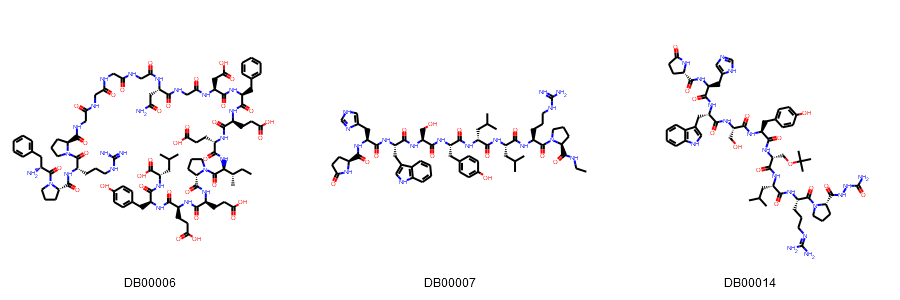

In [7]:
img=Draw.MolsToGridImage(mols[:3],molsPerRow=3,subImgSize=(300,300), legends = [x.GetProp("DRUGBANK_ID") for x in mols[:3]])
img

In [24]:
drugbank_morganFP=[AllChem.GetMorganFingerprintAsBitVect(mol,2, nBits=1024) for mol in mols if mol is not None]

In [25]:
drugbank_ID = [mol.GetProp('DRUGBANK_ID') for mol in mols if mol is not None]

In [26]:
drugbank_train_data=np.asarray(drugbank_morganFP, dtype=np.int32)
drugbank_labels=np.asarray(drugbank_ID, dtype=np.object).reshape(-1,1)

In [27]:
print('Training Data Dimension:',drugbank_train_data.shape)
print('Labels Dimension:',drugbank_labels.shape)

Training Data Dimension: (11575, 1024)
Labels Dimension: (11575, 1)


### Test Random Forest Classifier on Drug Bank data

In [30]:
drugbank_predicted=rf_clf.predict(drugbank_train_data)
drugbank_predicted

array([1., 0., 0., ..., 0., 0., 1.])

In [31]:
drugbank_predicted_df=pd.DataFrame(drugbank_predicted, columns=['Predicted Class'])
drugbank_labels_df=pd.DataFrame(drugbank_labels, columns=['DrugBank ID'])
result=pd.concat([drugbank_labels_df,drugbank_predicted_df], axis=1)
result

,DrugBank ID,Predicted Class
0,DB00006,1.0
1,DB00007,0.0
2,DB00014,0.0
3,DB00027,0.0
4,DB00035,0.0
...,...,...
11570,DB17379,0.0
11571,DB17383,0.0
11572,DB17384,0.0
11573,DB17385,0.0


### Select all active class

In [33]:
actives=result[result['Predicted Class']==1]
actives

,DrugBank ID,Predicted Class
0,DB00006,1.0
15,DB00119,1.0
17,DB00121,1.0
19,DB00123,1.0
20,DB00125,1.0
...,...,...
11513,DB17147,1.0
11523,DB17161,1.0
11526,DB17168,1.0
11540,DB17223,1.0


Nearly 83% of the molecules in the Drug Bank data base are active. Is this accurate? Let's use prediction probabilities for actives and inactives for a better representation.

### Active (1)/Inactive (0) Class Probabilities

In [34]:
drugbank_predicted_prob=rf_clf.predict_proba(drugbank_train_data)
drugbank_predicted_prob

array([[0.49862507, 0.50137493],
       [0.52357807, 0.47642193],
       [0.51688051, 0.48311949],
       ...,
       [0.58428365, 0.41571635],
       [0.6631649 , 0.3368351 ],
       [0.49376481, 0.50623519]])

In [35]:
drugbank_predicted_prob_df=pd.DataFrame(drugbank_predicted_prob, columns=['Pred_prob 0', 'Pred_prob 1'])
drugbank_labels_df=pd.DataFrame(drugbank_labels, columns=['DrugBank ID'])
result_prob=pd.concat([drugbank_labels_df,drugbank_predicted_prob_df], axis=1)
result_prob

,DrugBank ID,Pred_prob 0,Pred_prob 1
0,DB00006,0.498625,0.501375
1,DB00007,0.523578,0.476422
2,DB00014,0.516881,0.483119
3,DB00027,0.502754,0.497246
4,DB00035,0.601171,0.398829
...,...,...,...
11570,DB17379,0.864670,0.135330
11571,DB17383,0.644208,0.355792
11572,DB17384,0.584284,0.415716
11573,DB17385,0.663165,0.336835


In [41]:
actives_=result_prob[result_prob['Pred_prob 1']>0.85]
actives_

,DrugBank ID,Pred_prob 0,Pred_prob 1
6387,DB08073,0.118733,0.881267
6859,DB08568,0.117163,0.882837
7992,DB11694,0.054892,0.945108
9866,DB13930,0.127463,0.872537
10591,DB15281,0.008916,0.991084


Five active candidates with probability > 0.85.

Among the five candidates DB13930, Ulixertinib is a proven ERK2 inhibitor with high potency and selectivity. https://go.drugbank.com/drugs/DB13930
